# 목적: PageRank를 사용하여 문서의 중요 명사 랭크
# Goal: Rank important keywords in documents using PageRank algorithm

In [ ]:
from konlpy.tag import Kkma
from ckonlpy.tag import Twitter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from datetime import date
import numpy as np
import pandas as pd
import operator

In [ ]:
class SentenceTokenizer(object):
    def __init__(self):
        self.kkma=Kkma()
        self.twitter=Twitter()
        
        #### 사전 추가 영역 ###
        self.twitter.add_dictionary(['협조전','보고전','경조사비'],'Noun')
        self.stopwords=['사유','사항','아래','확인']
    def text2sentences(self,df_text):
        sentence=[]
        for idx in range(len(df_text)):
            sentences.append(df_text[idx])
        return sentences
    
    def get_nouns(self,sentences):
        nouns=[]
        for sentence in sentences:
            if sentence is not '':
                nouns.append(' '.join([noun for noun in self.twitter.nouns(str(sentence))
                                      if noun not in self.stopwords and len(noun)>1]))
        
        return nouns

In [ ]:
class GraphMatrix(object):
    def __init__(self):
        self.tfidf=TfidfVectorizer()
        self.cnt_vec=CountVectorizer()
        self.graph_sentence=[]
        
    def build_sent_graph(self,sentence):
        tfidf_mat=self.tfidf.fit_transform(sentence).toarray()
        self.graph_sentence=np.dot(tfidf_mat,tfidf_mat.T)
        return self.graph_sentence
    
    def build_word_graph(self,sentence):
        cnt_vec_mat=normalize(self.cnt_vec.fit_transform(sentence).toarray().astype(float),axis=0)
        vocab=self.cnt_vec.vocabulary_
        return np.dot(cnt_vec_mat.T,cnt_vec_mat), {vocab[word]:word for word in vocab}

In [ ]:
class Rank(object):
    def get_ranks(self, graph, d=0.85) # d= damping factor
        A=graph
        matrix_size=A.shape[0]
        for id in range(matrix_size):
            A[id,id]=0 # diagonal
            link_sum=np.sum(A[:,id]) # A[:,id]=A[:][id]
            if link_sum!=0:
                A[:,id]/=link_sum
            A[:,id]*=-d
            A[id,id]=1
            
        B=(1-d)*np.ones((matrix_size,1))
        ranks=np.linalg.solve(A,B) # Ax=b의 해
        return {idx:r[0] for idx,r in enumearte(ranks)}

In [ ]:
class TextRank(object):
    def __init__(self,df_text):
        self.sent_tokenize=SentenceTokenizer()
        self.sentences=self.sent_tokenize.text2sentences(df_text)
        
        self.nouns=self.sent_tokenize.get_nouns(self.sentences)
        
        self.graph_matrix=GraphMatrix()
        self.sent_graph=self.graph_matrix.build_sent_graph(self.nouns)
        self.words_graph,self.idx2word=self.graph_matrix.build_word_graph(self.nouns)
        
        self.rank=Rank()
        self.sent_rank_idx=self.rank.get_ranks(self.sent_graph)
        self.sorted_sent_rank_idx=sorted(self.sent_rank_idx,key=lambda k:self.sent_rank_idx[k],reverse=True)
        
        self.word_rank_idx=self.rank.get_ranks(self.words_graph)
        self.sorted_word_rank_idx=sorted(self.word_rank_idx,key=lambda k:self.word_rank_idx[k],reverse=True)
        
    def summarize(self,sent_num=3):
        summary=[]
        index=[]
        for idx in self.sorted_sent_rank_idx[:sent_num]:
            index.append(idx)
            
        index.sort()
        for idx in index:
            summary.append(self.sentences[idx])
            
        return summary
    
    def keywords(self, word_num=1000):
        rank=Rank()
        rank_idx=rank.get_ranks(self.words_graph)
        sorted_rank_idx=sorted(rank_idx,key=lambda k:rank_idx[k],reverse=True)
        
        keywords=[]
        index=[]
        for idx in sorted_rank_idx[:word_num]:
            index.append(idx)
            
        for idx in index:
            keywords.append(self.idx2word[idx])
            
        return keywords

## Cube 문서 인풋 데이터 호출
## Read input data (documents)

In [ ]:
### 이미지1
filename='./Data(Pagerank)/INPUT/그룹웨어정리_2018.csv'
filename2='./Data(Pagerank)/INPUT/그룹웨어정리_2019.csv'

df_cube=pd.read_csv(filename,error_bad_lines=False, encoding='cp949', engine='python')
df_cube2=pd.read_csv(filename2,error_bad_lines=False, encoding='cp949', engine='python')
df_cube_all=pd.concat([df_cube,df_cube2]).reset_index(drop=True)

df_cube_rev=pd.DataFrame()

# Raw Data (Cube 문서 제목) 필요 컬럼만 사용
df_cube_rev['COMP_CODE']=df_cube_all['PROCINST_COMP_CODE'].fillna('')
df_cube_rev['FORM_CODE']=df_cube_all['FORM_DESC'].fillna('')
df_cube_rev['DEPT_CODE']=df_cube_all['CUBE_DEPT_CODE'].fillna('')
df_cube_rev['CUBE_text']=df_cube_all['PROCINST_SUBJECT'].fillna('')
df_cube_rev['DATE']=df_cube_all['PROCINST_CREATE_DATE'].fillna('')
df_cube_rev.head()

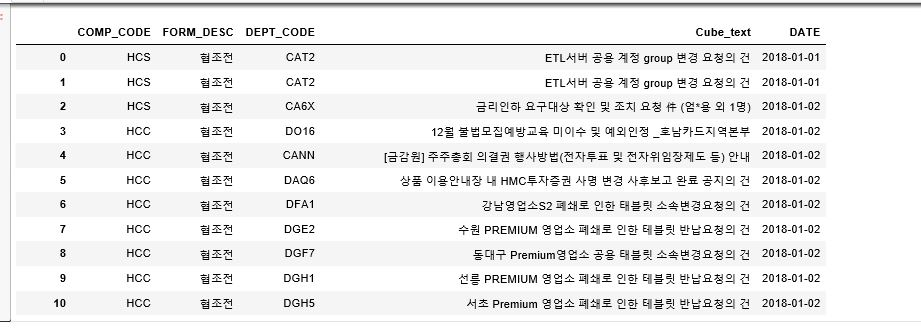

## Cube 데이터 - 회사별/부서별/문서종류별 PageRank Keywords 추출
## Get PageRank Keywords per department/ document type/ Company

In [ ]:
### 이미지2
keywords=[]
dept_list=[]
form=['협조전','품의서','시행문']
comp_code=np.unique(df_cube_rev['COMP_CODE'])
for l in comp_code:
    df_temp_comp=df_cube_rev[df_cubew_rev['COMP_CODE']==l]
    dept_code=np.unique(df_temp_comp['DEPT_CODE'])
    for i in form:
        df_temp=df_temp_comp[df_temp_comp['FORM_DESC']==i]
        for j in dept_code:
            if len(df_temp[df_temp['DEPT_CODE']==j])>200: # 해당 부서의 Cube 문서 제목 건수가 200개 이상인 부서만 추출하기 위함
                dept_list.append(l+'_'+i+'_'+j)
                df_temp2=df_temp[df_temp['DEPT_CODE']==j].reset_index(drop=True)
                textrank_temp=TextRank(df_temp2['Cube_text'])
                keywords_temp=textrank_temp.keywords()
                cc=0
                words_str=''
                if len(keywords_temp)<26:
                    for k in range(len(keywords_temp)):
                        if cc==0:
                            words_str=words_str+keywords_temp[k]
                            cc=1
                        else:
                            words_str=words_str+', 'keywords_temp[k]
                    keywords.append(words_str)
                else:
                    for k in range(25):
                        if cc==0:
                            words_str=words_str+keywords_temp[k]
                            cc=1
                        else:
                            words_str=words_str+', 'keywords_temp[k]
                    keywords.append(words_str)
            else:
                continue

df_TRkeywords=pd.DataFrame(np.concatenate((np.array(dept_list).reshape(-1,1),np.array(keywords).reshape(-1,1)),axis=1),columns=('FORM/DEPT','Text_Rank_Keywords'))

df_TRkeywords

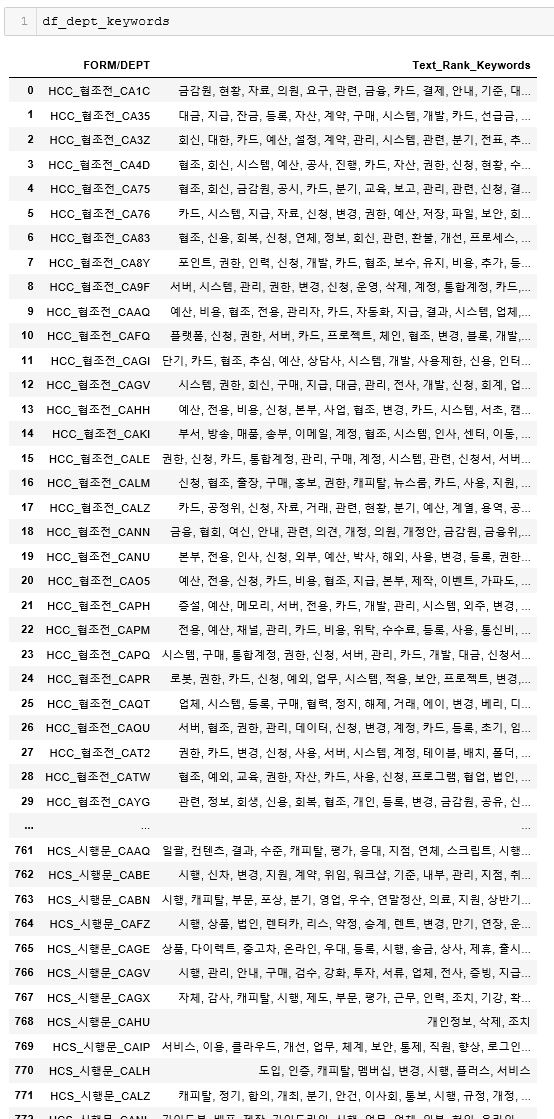

## Cube - 회사별/부서별/문서종류별 월별 tfidf 추출
## Get Monthly TFIDF value per department/ document type/ company

In [ ]:
### 이미지3
for dept in range(np.size(df_TRkeywords,axis=0)):
    target_code1=df_TRkeywords.iloc[dept,0].split('_')[0]
    target_code2=df_TRkeywords.iloc[dept,0].split('_')[2]
    target_code3=df_TRkeywords.iloc[dept,0].split('_')[1]
    df_cube_temp=df_cube_rev[df_cube_rev['COMP_CODE']==target_code1]
    df_cube_temp2=df_cube_temp[df_cube_temp['FORM_DESC']==target_code3]
    df_cube_team=df_cube_temp2[df_cube_temp2['COMP_CODE']==target_code2]
    
    df_cube_team=df_cube_team.reset_index(drop=True)
    
    ## 월별 리스트
    month_list=[]
    month_cnt=[]
    yyyymm=['' for i in range(len(df_cube_team))]
    df_cube_team['MONTH']=yyyymm
    m_cnt=1
    for idx in range(len(df_cube_team)):
        temp_month=df_cube_team['DATE'][idx].split('-')[0]+'-'+df_cube_team['DATE'][idx].split('-')[1]
        df_cube_team['MONTH'][idx]=temp_month
        try:
            if temp_month in month_list:
                m_cnt+=1
                continue
            else:
                month_list.append(temp_month)
                month_cnt.append(m_cnt)
                m_cnt=1
        except:
            continue
    del month_cnt[0] ## 첫번째를 제거해야 뽑으려고 하는 월별 카운트가 나옴
    month_cnt.append(m_cnt)
    
    
    ## 월별 문서 분류
    document_month=[]
    for i in range(len(month_list)):
        df_cube_team_month=df_cube_team[df_cube_team['MONTH']==month_list[i]]['Cube_text']
        temp=''
        cc=0
        for j,jj in enumerate(df_cube_team_month):
            if cc==0:
                temp=jj
                cc=1
            else:
                temp=temp+' '+jj
        document_month.append(temp)
        
    ## 월별 get_nouns
    docs_tokenize=SentenceTokenizer()
    docs_month=docs_tokenize.text2sentences(document_month)
    docs_nouns_month=docs_tokenize.get_nouns(docs_month)
    ## 월별 tfidf
    vect=TfidfVectorizer()
    tfidf_mat_month=vect.fit_transform(docs_nouns_month)
    tfidf_mat_month=tfidf_mat_month.toarray()
    feature_name_month=vect.get_feature_names()
    
    ## 월별 tfidf sort 및 월별로 concat
    cc=0
    for i in range(len(month_list)):
        if cc==0:
            temp=np.concatenate((np.array(feature_name_month).reshape(-1,1),np.array(tfidf_mat_month[i]).reshape(-1,1)),axis=1)
            temp_df=pd.DataFrame(temp,columns=('word','tfidf'))
            temp_df_sort=temp_df.sort_values(by='tfidf',ascending=False).reset_index(drop=True)
            temp_list=temp_df_sort[:300].values.tolist()
            temp_list_top50=[]
            for j in range(len(temp_list)):
                tmp=temp_list[j][0]+': '+temp_list[j][1]
                temp_list_top50.append(tmp)
            tfidf_month_list_sorted=np.array(temp_list_top50).reshape(-1,1)
            cc=1
        else:
            temp=np.concatenate((np.array(feature_name_month).reshape(-1,1),np.array(tfidf_mat_month[i]).reshape(-1,1)),axis=1)
            temp_df=pd.DataFrame(temp,columns=('word','tfidf'))
            temp_df_sort=temp_df.sort_values(by='tfidf',ascending=False).reset_index(drop=True)
            temp_list=temp_df_sort[:300].values.tolist()
            temp_list_top50=[]
            for j in range(len(temp_list)):
                tmp=temp_list[j][0]+': '+temp_list[j][1]
                temp_list_top50.append(tmp)
            tfidf_month_list_sorted=np.concatenate((tfidf_month_list_sorted,np.array(temp_list_top50).reshape(-1,1)),axis=1)
    df_tfidf_month=pd.DataFrame(tfidf_month_list_sorted)
    df_tfidf_month.columns=month_list
    df_tfidf_month.to_csv('./Data(Pagerank)/TEMP/tfidf/'+target_code1+'_'+target_code2+'_'+target_code3+'_월별_tfidf.csv',encoding='cp949')
    

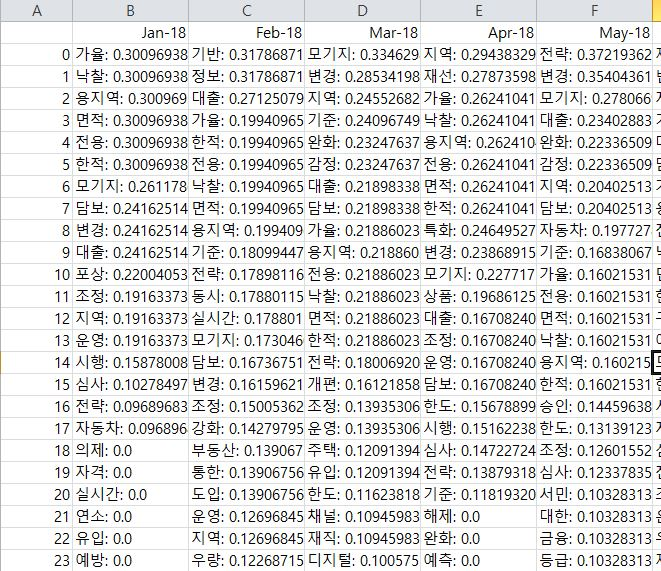